# 2-Sample Tests Power over Increasing Dimension

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [14]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

from benchmarks import power_2samp_dimension
from mgc.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from mgc.sims import *

sys.path.append(os.path.realpath('..'))

In [15]:
import seaborn as sns
sns.color_palette('Set1')
sns.set(color_codes=True, style='white', context='talk', font_scale=2, palette="colorblind")

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the sample sizes tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [16]:
from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class RManova:
    r"""
    Wrapper of statsmodels MANOVA
    """
    def __init__(self):
        self.stats = importr('stats')
        self.r_base = importr('base')
        
        numpy2ri.activate()

        self.formula = Formula('X ~ Y')
        self.env = self.formula.environment

    def _statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env['Y'] = y
        self.env['X'] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

        return stat

In [17]:
MAX_DIMENSION = 11
STEP_SIZE = 1
DIMENSIONS = range(1, MAX_DIMENSION, STEP_SIZE)
POWER_REPS = 3

In [18]:
simulations = [
    linear,
    exponential,
    cubic,
    joint_normal,
    step,
    quadratic,
    w_shaped,
    spiral,
    uncorrelated_bernoulli,
    logarithmic,
    fourth_root,
    sin_four_pi,
    sin_sixteen_pi,
    square,
    two_parabolas,
    circle,
    ellipse,
    diamond,
    multiplicative_noise,
    multimodal_independence
]

tests = [
    CCA,
    Dcorr,
    HHG,
    Hsic,
    RV,
    MGC,
    RManova,
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [46]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power_2samp_dimension(test, trans_2samp, sim, p=i, trans=0.2) for _ in range(POWER_REPS)])
                          for i in DIMENSIONS])
    np.savetxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [47]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

KeyboardInterrupt: 

In [37]:
_SIMS = [
    linear,
    spiral,
    exponential,
    cubic,
    joint_normal,
    step,
    quadratic,
    w_shaped,
    uncorrelated_bernoulli,
    logarithmic,
    fourth_root,
    sin_four_pi,
    sin_sixteen_pi,
    two_parabolas,
    circle,
    ellipse,
    diamond,
    multiplicative_noise,
    square,
    multimodal_independence,
]


def _2samp_rotate(sim, x, y, p, degree=90):
    angle = np.radians(degree)
    if sim.__name__ in [
        "joint_normal",
        "logarithmic",
        "sin_four_pi",
        "sin_sixteen_pi",
        "two_parabolas",
        "square",
        "diamond",
        "circle",
        "ellipse",
        "multiplicative_noise",
        "multimodal_independence",
    ]:
        rot_mat = np.identity(2 * p)
    else:
        rot_mat = np.identity(p + 1)
    rot_mat[np.ix_((0, 1), (0, 1))] = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    data = np.hstack([x, y])
    rot_data = (rot_mat @ data.T).T
    
    if sim.__name__ in [
        "joint_normal",
        "logarithmic",
        "sin_four_pi",
        "sin_sixteen_pi",
        "two_parabolas",
        "square",
        "diamond",
        "circle",
        "ellipse",
        "multiplicative_noise",
        "multimodal_independence",
    ]:
        x_rot, y_rot = np.hsplit(rot_data, 2)
    else:
        x_rot, y_rot = np.hsplit(rot_data, [p-1])

    return x_rot, y_rot


def rot_2samp(sim, n, p, noise=True, degree=90, trans=0):
    """Rotated 2 sample test"""
    if sim not in _SIMS:
        raise ValueError("Not valid simulation")

    if sim.__name__ == "multimodal_independence":
        x, y = sim(n, p)
        x_rot, y_rot = sim(n, p)
    else:
        if sim.__name__ == "multiplicative_noise":
            x, y = sim(n, p)
        else:
            x, y = sim(n, p, noise=noise)
        x_rot, y_rot = _2samp_rotate(sim, x, y, p, degree=degree)
    samp1 = np.hstack([x, y])
    samp2 = np.hstack([x_rot, y_rot])

    return samp1, samp2


def trans_2samp(sim, n, p, noise=False, degree=90, trans=0.3):
    """Translated 2 sample test"""
    if sim not in _SIMS:
        raise ValueError("Not valid simulation")

    if sim.__name__ == "multimodal_independence":
        x, y = sim(n, p)
        x_trans, y_trans = sim(n, p)
    else:
        if sim.__name__ == "multiplicative_noise":
            x, y = sim(n, p)
        else:
            x, y = sim(n, p, noise=noise)
        x_trans = x + trans
        x_trans, y_trans = _2samp_rotate(sim, x_trans, y, p, degree=degree)
    samp1 = np.hstack([x, y])
    samp2 = np.hstack([x_trans, y_trans])

    return samp1, samp2


def gaussian_3samp(n, epsilon, case=1):
    cov = np.identity(2)
    means = [0] * 3
    epsilons = [epsilon] * 3

    if case == 1:
        pass
    elif case == 2:
        epsilons = [0, 0, epsilon]
    elif case == 3:
        means = [0, -epsilon / 2, epsilon / 2]
        epsilons = [
            (np.sqrt(3) / 3) * epsilon,
            -(np.sqrt(3) / 6) * epsilon,
            -(np.sqrt(3) / 6) * epsilon,
        ]
    else:
        raise ValueError("Not valid case, must be 1, 2, or 3")

    total_means = list(zip(means, epsilons))
    sims = [np.random.multivariate_normal(mean, cov, n) for mean in total_means]

    return sims

In [45]:
x, y = trans_2samp(linear, 100, p=6, noise=False, degree=90, trans=0.3)
print(x, y)

[[-4.49855132e-01 -1.98782926e-01 -2.59951863e-01 -6.03120847e-01
   8.38414020e-01 -5.68648792e-01 -7.13769422e-01]
 [ 2.10617557e-02 -1.49602161e-01 -5.52303954e-01 -6.94064064e-01
  -6.01184869e-01 -2.30946316e-01 -5.70084685e-01]
 [ 7.47311496e-01 -6.34474630e-01  7.07058230e-01 -9.83832253e-01
   7.96434204e-01  3.57949532e-01  6.38747291e-01]
 [ 1.18062926e-01 -9.80245629e-01 -8.60100890e-01  9.44045239e-01
  -7.67890006e-01  8.33422121e-01 -4.37423189e-01]
 [-5.62217609e-02  1.47711540e-01 -2.70471004e-01  1.10487403e-01
   8.96588642e-02  2.90335858e-01  2.14199412e-02]
 [ 1.24247647e-02  6.33160057e-01 -5.64514216e-01 -9.90278864e-01
   5.98647261e-01  5.40348135e-01  1.03051147e-01]
 [ 7.31156735e-01 -8.83956599e-01  9.35577064e-01 -3.44276574e-01
  -9.03208121e-01  5.16044515e-01  4.20334108e-01]
 [ 6.09799025e-01 -4.86009860e-01 -8.24781333e-01  8.87716757e-01
  -8.43729004e-01 -2.13854237e-01  1.09408000e-01]
 [-8.14647148e-02  7.06354376e-01  6.36187220e-01  6.52934003e-0

The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

In [19]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = simulations[count]
            
            for test in tests:
                mgc_power = np.genfromtxt('../benchmarks/2samp_vs_dimension/{}_MGC.csv'.format(sim.__name__),
                                          delimiter=',')
                power = np.genfromtxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
                                      delimiter=',')
                
                custom_color = {
                    "Dcorr" : "b-",
                    "Hsic" : "g-",
                    "RManova" : "y-",
                    "MGC" : "r-"
                }
                if test.__name__ in custom_color.keys():
                    if test.__name__ == "MGC":
                        col.plot(DIMENSIONS, power - mgc_power, custom_color[test.__name__], label=test.__name__, lw=5)
                    else:
                        col.plot(DIMENSIONS, power - mgc_power, custom_color[test.__name__], label=test.__name__, lw=3)
                else:
                    col.plot(DIMENSIONS, power - mgc_power, label=test.__name__, lw=1)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([DIMENSIONS[0], DIMENSIONS[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.08, 'Dimension', ha='center')
    fig.text(0.08, 0.5, 'Absolute Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../benchmarks/figs/2samp_power_dimension.pdf', transparent=True, bbox_inches='tight')

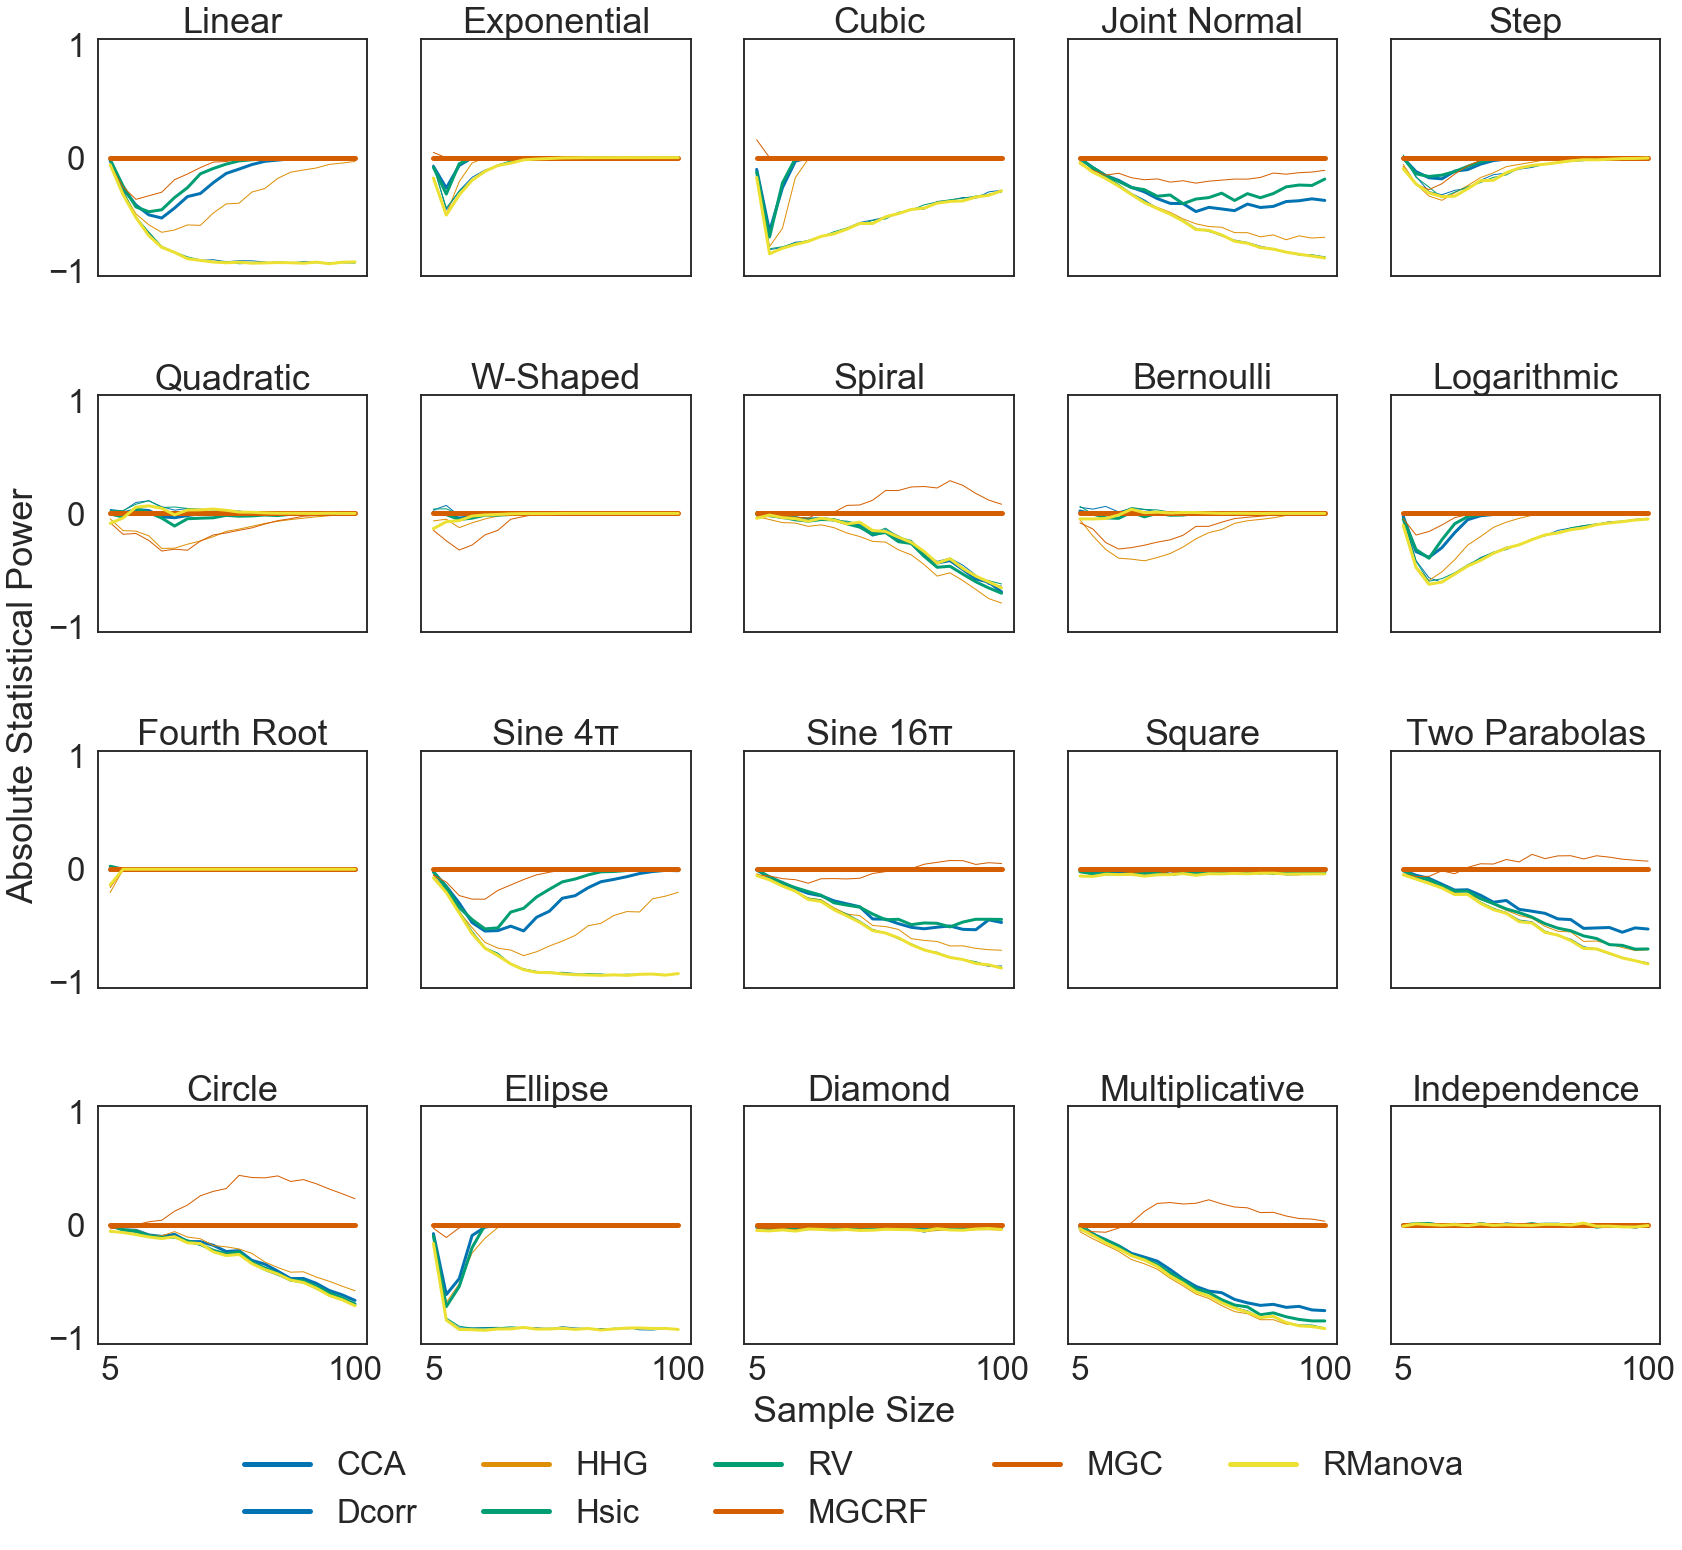

In [20]:
plot_power()